In [20]:
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

In [21]:
users = pd.read_csv('dataset/Users.csv')
ratings = pd.read_csv('dataset/Ratings.csv')
df = pd.merge(users, ratings, on='User-ID', how='inner')
df.drop(['Location', 'Age'], axis=1, inplace=True)
df.head()

User-ID        ISBN  Book-Rating
0        2  0195153448            0
1        7   034542252            0
2        8  0002005018            5
3        8  0060973129            0
4        8  0374157065            0

In [22]:
# Ratings distribution

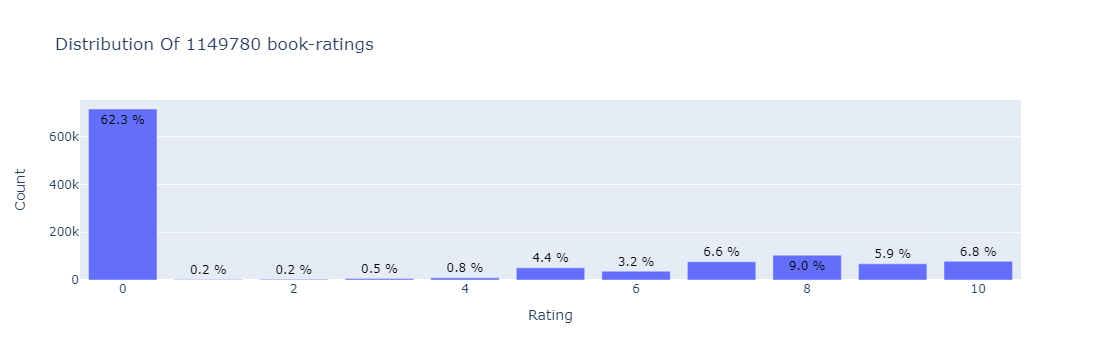

In [23]:

from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

data = df['Book-Rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} book-ratings'.format(df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [24]:
# Ratings distribution by book

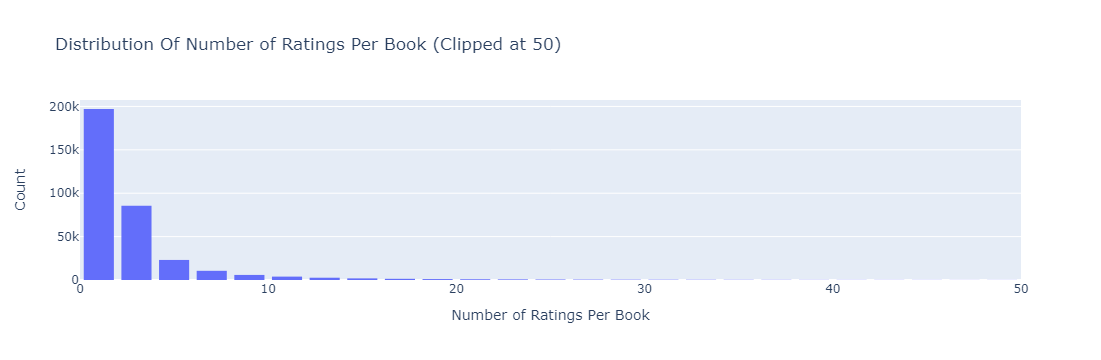

In [25]:

# Number of ratings per book
data = df.groupby('ISBN')['Book-Rating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Book (Clipped at 50)',
                   xaxis = dict(title = 'Number of Ratings Per Book'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [26]:
df.groupby('ISBN')['Book-Rating'].count().reset_index().sort_values('Book-Rating', ascending=False)[:10]

ISBN  Book-Rating
247408  0971880107         2502
47371   0316666343         1295
83359   0385504209          883
9637    0060928336          732
41007   0312195516          723
101670  044023722X          647
166705  0679781587          639
28153   0142001740          615
166434  067976402X          614
153620  0671027360          586

In [27]:
#Ratings distribution by user

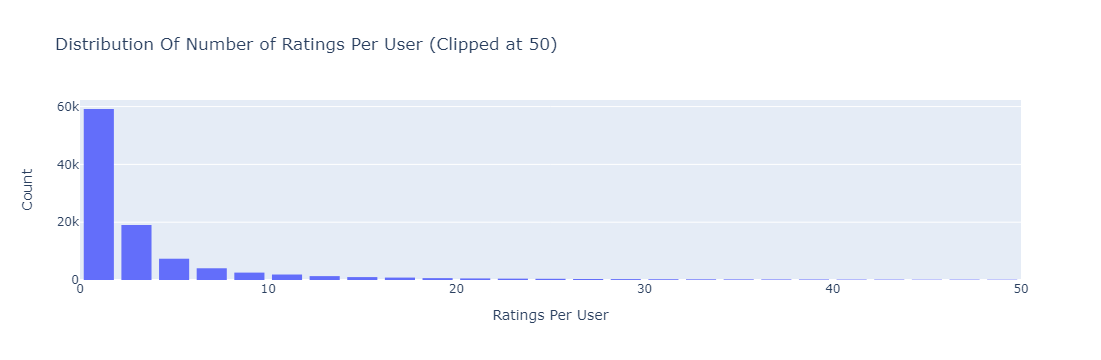

In [28]:
# Number of ratings per user
data = df.groupby('User-ID')['Book-Rating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User (Clipped at 50)',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [29]:
df.groupby('User-ID')['Book-Rating'].count().reset_index().sort_values('Book-Rating', ascending=False)[:10]

User-ID  Book-Rating
4213      11676        13602
74815    198711         7550
58113    153662         6109
37356     98391         5891
13576     35859         5850
80185    212898         4785
105111   278418         4533
28884     76352         3367
42037    110973         3100
88584    235105         3067

In [30]:
#Reduce dimensionality of the dataset

In [31]:
## Explicit Ratings Dataset
explicit_ratings = df[df['Book-Rating'] != 0]
explicit_ratings = explicit_ratings.reset_index(drop = True)
explicit_ratings.shape
print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(explicit_ratings.shape))

The original data frame shape:	(1149780, 3)
The new data frame shape:	(433671, 3)


In [32]:
min_book_ratings = 50
filter_books = explicit_ratings['ISBN'].value_counts() > min_book_ratings
filter_books = filter_books[filter_books].index.tolist()

min_user_ratings = 50
filter_users = explicit_ratings['User-ID'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = explicit_ratings[(explicit_ratings['ISBN'].isin(filter_books)) & (explicit_ratings['User-ID'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(explicit_ratings.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(433671, 3)
The new data frame shape:	(13716, 3)


In [33]:
# Surprise

In [34]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(df_new[['User-ID', 'ISBN', 'Book-Rating']], reader)

In [35]:

benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp._append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


test_rmse  fit_time  test_time
Algorithm                                      
SVD               1.544725  0.088999   0.038999
SVDpp             1.545983  0.266707   0.138288
BaselineOnly      1.549059  0.010345   0.013630
CoClustering      1.648824  0.254019   0.016328
KNNWithMeans      1.684002  0.041336   0.120982
KNNBaseline       1.691556  0.041654   0.152011
KNNWithZScore     1.712828  0.074667   0.120009
KNNBasic          1.801797  0.031661   0.119346
SlopeOne          1.806676  0.019651   0.056349
NormalPredictor   2.311269  0.008027   0.014987
NMF               2.609973  0.189651   0.020320

In [36]:
#SVD train and predict

In [37]:
algo = SVD()
trainset, testset = train_test_split(data, test_size=0.25)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 1.5727


1.5727447678662096

In [38]:
def get_NumUserRatings(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_NumBookRatings(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['UserID', 'ISBN', 'Rating', 'EstRating', 'details'])
df['NumUserRatings'] = df.UserID.apply(get_NumUserRatings)
df['NumBookRatings'] = df.ISBN.apply(get_NumBookRatings)
df['err'] = abs(df.EstRating - df.Rating)
df = df.drop('details', axis=1)
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [39]:
best_predictions

UserID        ISBN  Rating  EstRating  NumUserRatings  NumBookRatings  \
584   153662  0345339703    10.0  10.000000              34              21   
842   242106  0439136350    10.0  10.000000               9              48   
1370  227705  0440220602     8.0   7.999705              20              30   
2741  140358  0451167317     5.0   4.999499              36              26   
849    15049  089480829X     8.0   7.999186               5              15   
937   112001  0743457358     9.0   9.001914              21               7   
1260   60244  014029628X     8.0   8.003149              57              23   
2880  270605  0060976845     6.0   5.995583              17              32   
2095   78973  0345413903     8.0   7.995356              29              14   
452    11676  044023722X     8.0   7.995058             235              31   

           err  
584   0.000000  
842   0.000000  
1370  0.000295  
2741  0.000501  
849   0.000814  
937   0.001914  
1260  0.003149  
2880  0.004417  
2095  0.004644  
452   0.004942

In [40]:
worst_predictions

UserID        ISBN  Rating  EstRating  NumUserRatings  NumBookRatings  \
1700   66942  0804114986     2.0   8.154263              23              25   
597   219683  0316769487     1.0   7.184795              20              41   
336    75819  0316769487     2.0   8.230025              14              41   
1553  161041  0060977493     1.0   7.299988               3              20   
1029   11676  044021145X     1.0   7.526095             235              47   
2577  257700  0316769487     2.0   8.686831               5              41   
2971  135458  0441569595     1.0   7.832776               3              11   
1152   82511  0767900383     1.0   7.996872               2              12   
3300  121170  0553260111     1.0   7.998383              16              18   
2973  140036  0316769487     1.0   8.221531               0              41   

           err  
1700  6.154263  
597   6.184795  
336   6.230025  
1553  6.299988  
1029  6.526095  
2577  6.686831  
2971  6.832776  
1152  6.996872  
3300  6.998383  
2973  7.221531

In [43]:
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display, Javascript
%matplotlib notebook

In [44]:
df_new.loc[df_new['ISBN'] == '0316776963']['Book-Rating'].hist()
iplot(df_new)

<IPython.core.display.Javascript object>